In [3]:
import time
import cmath
import json
from collections import defaultdict
from typing import List, Dict, Callable

import numpy as np
import qutip as qtp
from matplotlib import pyplot as plt

from pysqkit import qubits, drives, couplers
from pysqkit import QubitSystem, Qubit
from pysqkit.util.linalg import get_mat_elem
from pysqkit.util.phys import temperature_to_thermalenergy



from IPython.display import display, Latex

In [2]:
def extract_trans_freqs(transmon: Qubit, fluxonium: Qubit) -> Dict[str, float]:
    """
    Description
    --------------------------------------------------------------
    Returns the transition frequencies that lead to frequency collisions.
    """
    results = dict()
    coupled_levels = dict(
        fluxonium = [("0", "1"), ("1", "2"), ("0", "3"), ("1", "4")],
        transmon = [("0", "1"), ("1", "2"), ("0", "2")]
    )
    for qubit in (transmon, fluxonium):
        label = qubit.label
        
        for level_i, level_j in coupled_levels[label]:
            freq_i = qubit.state(level_i)[0]
            freq_j = qubit.state(level_j)[0]
            trans_freq = freq_j - freq_i
            results[f"{label}_freq_{level_i}_{level_j}"] = trans_freq
    return results
    

def zz_crosstalk(system: QubitSystem) -> float:
    """
    Description
    --------------------------------------------------------------
    Returns the residual ZZ coupling at zero drive.
    """
    
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def cr_coeff(
    comp_states: Dict, 
    system: QubitSystem,
    eps_drive: float
) -> float:
    
    """
    Description
    --------------------------------------------------------------
    Returns the YZ coefficient associated with the charge 
    operator of the fluxonium in the dressed basis.
    """
    
    op = coupled_sys["F"].charge_op()
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return np.abs((np.imag(yz0 - yz1))/2)*eps_drive/2

In [4]:
with open('flx_transm_params.txt') as param_file:
    PARAM_SETS = json.load(param_file)
    
PARAMS = PARAM_SETS["2"] # Choosing the second parameter set

In [5]:
TEMP = 0.020 # K
D_COMP = 4
LEVELS_TRANSMON = 3
LEVELS_FLUXONIUM = 5

thermal_energy = temperature_to_thermalenergy(TEMP) # kb T/h in GHz

#Transmon
transmon = qubits.SimpleTransmon(
    label='transmon', 
    max_freq=PARAMS["max_freq_t"], 
    anharm=PARAMS["anharm_t"],
    diel_loss_tan=PARAMS["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=LEVELS_TRANSMON,
    dephasing_times=PARAMS["dephasing_times_t"]
)

#Fluxonium
fluxonium = qubits.Fluxonium(
    label='fluxonium', 
    charge_energy=PARAMS["charge_energy_f"], 
    induct_energy=PARAMS["induct_energy_f"], 
    joseph_energy=PARAMS["joseph_energy_f"], #8.0, 
    diel_loss_tan=PARAMS["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times=PARAMS["dephasing_times_f"] #ns/2*np.pi 
)
fluxonium.diagonalize_basis(LEVELS_FLUXONIUM)

d_leak = LEVELS_TRANSMON*LEVELS_TRANSMON - D_COMP

jc = PARAMS["jc"]
coupled_sys = transmon.couple_to(fluxonium, coupling=couplers.capacitive_coupling, strength=jc)
bare_system = transmon.couple_to(fluxonium, coupling=couplers.capacitive_coupling, strength=0.0)

state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

In [29]:
%%timeit
extract_trans_freqs(transmon, fluxonium)

51.9 ms ± 3.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
induct_energy = PARAMS["induct_energy_f"]
energy_offsets = np.linspace(-induct_energy*1e-1, induct_energy*1e-1, 100)

results = defaultdict(list)
for offset in energy_offsets:
    fluxonium.induct_energy = induct_energy + offset
    trans_freqs = extract_trans_freqs(transmon, fluxonium)
    for freq_label, freq_val in trans_freqs.items():
        results[freq_label].append(freq_val)

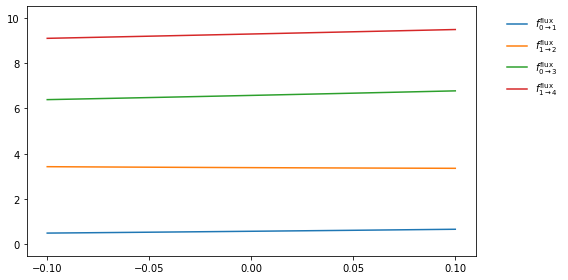

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
for freq_key in results.keys():
    qubit_label, _, level_i, level_j = freq_key.split("_")
    if qubit_label == "fluxonium":
        label = f"$f^{{\mathrm{{flux}}}}_{{{level_i} \\rightarrow {level_j}}}$"
        ax.plot(energy_offsets / induct_energy, results[freq_key], label=label)
    
    
ax.set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylim(-0.5, 10.5)
plt.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
)
plt.tight_layout()
plt.show()

In [35]:
joseph_energy = PARAMS["joseph_energy_f"]
energy_offsets = np.linspace(-induct_energy*2e-1, induct_energy*2e-1, 100)

results = defaultdict(list)
for offset in energy_offsets:
    fluxonium.joseph_energy = joseph_energy + offset
    trans_freqs = extract_trans_freqs(transmon, fluxonium)
    for freq_label, freq_val in trans_freqs.items():
        results[freq_label].append(freq_val)

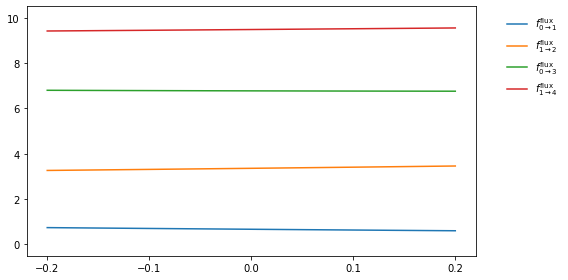

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
for freq_key in results.keys():
    qubit_label, _, level_i, level_j = freq_key.split("_")
    if qubit_label == "fluxonium":
        label = f"$f^{{\mathrm{{flux}}}}_{{{level_i} \\rightarrow {level_j}}}$"
        ax.plot(energy_offsets / induct_energy, results[freq_key], label=label)
    
    
ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_ylim(-0.5, 10.5)
plt.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
)
plt.tight_layout()
plt.show()

# Transmon-transmon freq assignment and layout

In [1]:
from typing import List
from layouts import Layout, surface_code
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def set_freq_groups(layout : Layout) -> None:
    num_groups = 5
    group_assign_order = ["north_east", "north_west", "south_east", "south_west"]

    qubits = layout.get_qubits()
    init_qubit = qubits.pop()
    init_group = 0

    set_qubits = set()
    assigned_qubits = set()

    def dfs_assign(qubit, freq_group):
        if qubit not in assigned_qubits:
            layout.set_param("freq_group", qubit, freq_group + 1)
            assigned_qubits.add(qubit)

            neighbors_dict = layout.param("neighbors", qubit)
            for direction, neighbour in neighbors_dict.items():
                if neighbour: #Supports more explicit syntax where absent neighbours are set as none
                    group_shift = group_assign_order.index(direction) + 1
                    neighbor_freq_group = (freq_group + group_shift) % num_groups
                    dfs_assign(neighbour, neighbor_freq_group)

    dfs_assign(init_qubit, init_group)
    
def set_target_freqs(layout : Layout, group_freqs : List[float],  group_anharms : List[float]) -> None:
    if len(group_freqs) != 5:
        raise ValueError("5 distinct qubit frequencies are required for the square layout.")
    qubits = layout.get_qubits()
    
    for qubit in qubits:
        try:
            freq_group = layout.param("freq_group", qubit)
        except KeyError:
            raise ValueError(f"Layout does not define a frequency group for qubit {qubit}.")
    
        if freq_group is None:
            raise ValueError(f"Layout does not define a frequency group for qubit {qubit}.")
            
        target_freq = group_freqs[freq_group - 1]
        layout.set_param("target_freq", qubit, target_freq)
        
        anharm = group_anharms[freq_group - 1]
        layout.set_param("anharm", qubit, anharm)

In [3]:
DISTANCE = 5
layout = surface_code(DISTANCE)

In [4]:
GROUP_FREQS = [5.000, 5.070, 5.140, 5.210, 5.280]
GROUP_ANHARMS = [-0.330, -0.330, -0.330, -0.330, -0.330]

set_freq_groups(layout)
set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

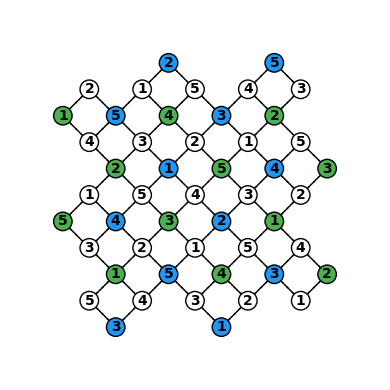

In [5]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

In [6]:
from layouts.transmon_scan_util import sample_freqs, get_collisions

In [7]:
sampled_collisions = []
freq_var = 0.001

for seed in range(10000):
    sample_freqs(layout, seed, freq_var)
    collisions = get_collisions(layout)
    sampled_collisions.append(collisions)

In [8]:
total_collisions = np.sum(sampled_collisions, axis=1)

In [10]:
np.sum(total_collisions == 0)

2

In [11]:
2/10000

0.0002

In [12]:
freq_var * np.array(GROUP_FREQS) * 1e3

array([5.  , 5.07, 5.14, 5.21, 5.28])

In [13]:
np.sum(sampled_collisions, axis=0)

array([   209,    171, 155467])